# Preprocessing

In [1]:
!pip install pydub
!pip install tensorflow
!pip install pandas scikit-learn librosa

In [2]:
import os
import shutil
import numpy as np
import librosa
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from pydub import AudioSegment
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Conv1D
from keras.layers import Convolution2D as Conv2D
from keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import argparse

In [3]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/My Drive/my dataset"

Mounted at /content/drive


In [5]:
# Splits dataset into training, validation, and testing data
def split_dataset_by_speakers(data, labels, test_size=0.2, random_state=33):

    # Encodes speaker labels
    labels_encoder = LabelEncoder().fit(labels)
    labels_encoded = labels_encoder.transform(labels)
    speaker_labels = to_categorical(labels_encoded)

    X_train, X_test, y_train, y_test = train_test_split(data, speaker_labels, test_size=test_size, random_state=random_state, stratify=speaker_labels)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_size, random_state=random_state, stratify=y_train)

    print("train")
    print(len(X_train))
    print("val")
    print(len(X_val))
    print("test")
    print(len(X_test))

    return X_train, X_val, X_test, y_train, y_val, y_test

# Extracts features from audio files to get data and chunks the audio files into 3-seconds
def extract_features(audio_file, chunk_seconds=3):
    y, sr = librosa.load(audio_file, sr=16000)
    chunks = sr * chunk_seconds
    y /= np.max(np.abs(y), axis=0)
    all_melspec =[]
    for i in range (0, len(y), chunks):
      if (i + chunks > len(y)):
        break
      # Obtains Mel-spectrograms from audio
      melspec = librosa.feature.melspectrogram(y=y[i:i+chunks], sr=sr, n_fft=1024, n_mels=128, center=True, hop_length = int(1024/2))
      melspec = librosa.power_to_db(melspec, ref=1.0)
      all_melspec.append(melspec)
    return all_melspec

#Loads audio data and labels
def load_data_from_folder(folder_path):
    data = []
    labels = []

    for speaker_folder in os.listdir(folder_path):
        speaker_path = os.path.join(folder_path, speaker_folder)
        for audio_file in os.listdir(speaker_path):
            audio_path = os.path.join(speaker_path, audio_file)
            features = extract_features(audio_path)
            data.extend(features)
            labels.extend([speaker_folder for _ in range(0, len(features))])
    return data, labels

# Specifies the path to my folder with the subfolders of audio files
main_folder_path = "/content/drive/My Drive/my dataset"

data, labels = load_data_from_folder(main_folder_path)
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset_by_speakers(data, labels, test_size=0.2, random_state=33)
print('X_train:', len(X_train), 'X_val:', len(X_val), 'X_test:', len(X_test), 'y_train:', len(y_train), 'y_val:', len(y_val), 'y_test:', len(y_test))
print ('Splitting is complete.')

train
8483
val
2121
test
2652
X_train: 8483 X_val: 2121 X_test: 2652 y_train: 8483 y_val: 2121 y_test: 2652
Splitting is complete.


# SimpleNet Model

In [ ]:
class SimpleNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First convolutional layer and activation layer as relu
        model.add(Conv2D(32, (3, 3), input_shape=inputShape, padding="same"))
        model.add(Activation("relu"))

        # MaxPooling layer for downsampling
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        # Second conv and activation layers
        model.add(Conv2D(16, (3,3), padding="same"))
        model.add(Activation("relu"))

        # Third conv and activation layers
        model.add(Conv2D(8, (3,3), padding="same"))
        model.add(Activation("relu"))

        # Softmax classifier
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(classes, activation='softmax'))

        model.summary()
        return model

In [ ]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.005)
model = SimpleNet.build(width=94, height=128, depth=1, classes=284)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 94, 32)       320       
                                                                 
 activation (Activation)     (None, 128, 94, 32)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 47, 16)        4624      
                                                                 
 activation_1 (Activation)   (None, 64, 47, 16)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 47, 8)         1160      
                                     

In [ ]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)),
              batch_size=8, epochs=100, verbose=1)

Training network...
Epoch 1/100
1061/1061 [==============================] - 12s 7ms/step - loss: 5.6446 - accuracy: 0.0053 - val_loss: 5.6160 - val_accuracy: 0.0108
Epoch 2/100
1061/1061 [==============================] - 6s 6ms/step - loss: 5.4292 - accuracy: 0.0191 - val_loss: 5.0937 - val_accuracy: 0.0372
Epoch 3/100
1061/1061 [==============================] - 6s 6ms/step - loss: 4.5453 - accuracy: 0.0753 - val_loss: 4.4208 - val_accuracy: 0.0731
Epoch 4/100
1061/1061 [==============================] - 6s 5ms/step - loss: 3.3735 - accuracy: 0.2089 - val_loss: 3.4006 - val_accuracy: 0.2070
Epoch 5/100
1061/1061 [==============================] - 8s 7ms/step - loss: 1.8254 - accuracy: 0.5228 - val_loss: 2.7024 - val_accuracy: 0.3498
Epoch 6/100
1061/1061 [==============================] - 6s 6ms/step - loss: 0.4255 - accuracy: 0.8814 - val_loss: 3.2984 - val_accuracy: 0.3465
Epoch 7/100
1061/1061 [==============================] - 7s 7ms/step - loss: 0.1140 - accuracy: 0.9683 - val_

In [ ]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

Evaluating network...
332/332 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

      aaj001       0.50      0.56      0.53         9
      aaj002       0.78      0.70      0.74        10
      abl001       0.57      0.36      0.44        11
      acf001       0.47      0.78      0.58         9
      acl001       0.12      0.14      0.13         7
      acr001       0.33      0.50      0.40         8
      adl001       0.62      0.73      0.67        11
      ais001       0.80      0.73      0.76        11
      ajh001       0.58      0.58      0.58        12
      ajm002       0.86      0.67      0.75         9
      ajt001       0.93      0.76      0.84        17
      ald001       0.50      0.60      0.55        20
      alw001       0.25      0.25      0.25         8
      aor001       0.47      0.78      0.58         9
      apc001       0.56      0.56      0.56         9
      apd001       0.67      0.89      0.76         9
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


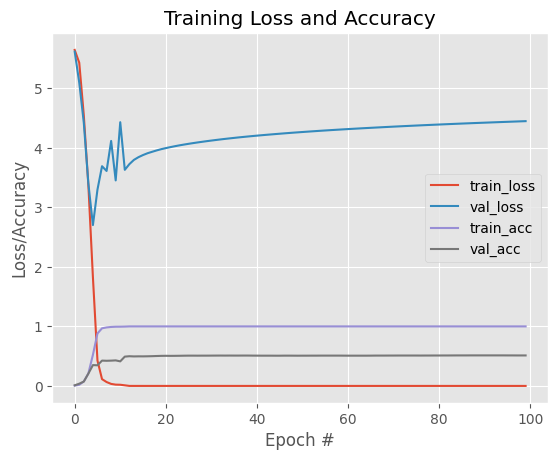

In [ ]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 1s 2ms/step
Confusion Matrix:
[[5 0 0 ... 0 0 0]
 [0 7 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 6 0]
 [0 0 0 ... 0 0 4]]
Accuracy: 0.5113122171945701


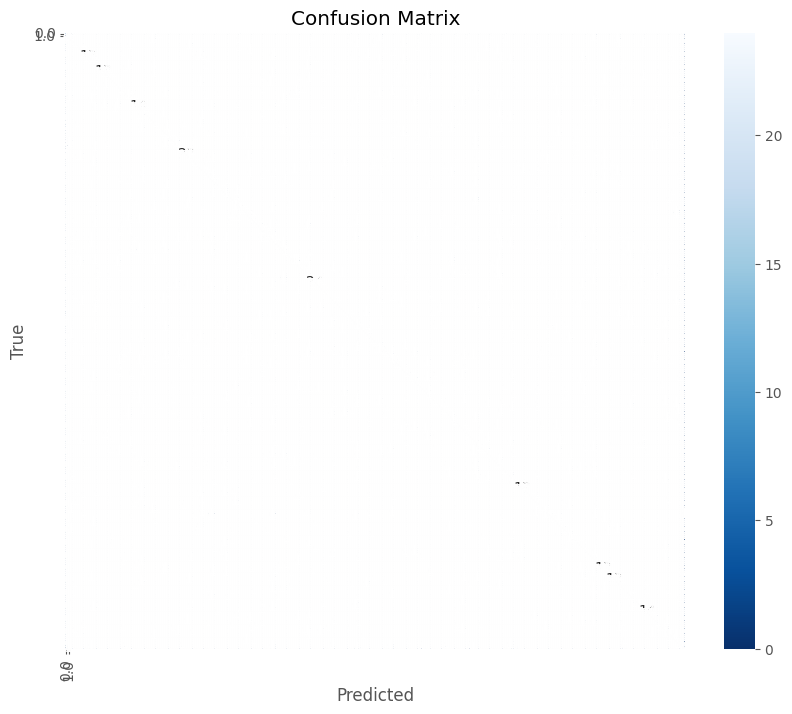

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ShallowNet Model

In [ ]:
class ShallowNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First convolutional layer and activation layer as relu
        model.add(Conv2D(32, (3, 3), input_shape=inputShape, padding="same"))
        model.add(Activation("relu"))

        # MaxPooling layer for downsampling
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

        # Second conv and activation layers
        model.add(Conv2D(16, (3,3), padding="same"))
        model.add(Activation("relu"))

        # Third conv and activation layers
        model.add(Conv2D(8, (3,3), padding="same"))
        model.add(Activation("relu"))

        # Fourth conv and activation layers
        model.add(Conv2D(8, (3,3), padding="same"))
        model.add(Activation("relu"))

        # Fifth conv and activation layers
        model.add(Conv2D(4, (3,3), padding="same"))
        model.add(Activation("relu"))

        # Softmax classifier
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(classes, activation='softmax'))

        model.summary()
        return model

In [ ]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.005)
model = ShallowNet.build(width=94, height=128, depth=1, classes=284)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 94, 32)       320       
                                                                 
 activation_3 (Activation)   (None, 128, 94, 32)       0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 47, 16)        4624      
                                                                 
 activation_4 (Activation)   (None, 64, 47, 16)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 47, 8)         1160      
                                   

In [ ]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)),
              batch_size=8, epochs=100, verbose=1)

Training network...
Epoch 1/100
1061/1061 [==============================] - 10s 8ms/step - loss: 5.6298 - accuracy: 0.0073 - val_loss: 5.5648 - val_accuracy: 0.0113
Epoch 2/100
1061/1061 [==============================] - 6s 6ms/step - loss: 5.2717 - accuracy: 0.0276 - val_loss: 4.7672 - val_accuracy: 0.0500
Epoch 3/100
1061/1061 [==============================] - 8s 7ms/step - loss: 4.0965 - accuracy: 0.1162 - val_loss: 3.9199 - val_accuracy: 0.1231
Epoch 4/100
1061/1061 [==============================] - 6s 6ms/step - loss: 2.4567 - accuracy: 0.4045 - val_loss: 3.1106 - val_accuracy: 0.3777
Epoch 5/100
1061/1061 [==============================] - 7s 7ms/step - loss: 0.9120 - accuracy: 0.7549 - val_loss: 2.0273 - val_accuracy: 0.5483
Epoch 6/100
1061/1061 [==============================] - 6s 6ms/step - loss: 0.3131 - accuracy: 0.9068 - val_loss: 2.3793 - val_accuracy: 0.5549
Epoch 7/100
1061/1061 [==============================] - 7s 7ms/step - loss: 0.1662 - accuracy: 0.9512 - val_

In [ ]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

Evaluating network...
332/332 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

      aaj001       1.00      0.89      0.94         9
      aaj002       0.89      0.80      0.84        10
      abl001       0.70      0.64      0.67        11
      acf001       0.62      0.56      0.59         9
      acl001       0.67      0.57      0.62         7
      acr001       0.50      0.62      0.56         8
      adl001       0.90      0.82      0.86        11
      ais001       0.91      0.91      0.91        11
      ajh001       0.64      0.58      0.61        12
      ajm002       0.82      1.00      0.90         9
      ajt001       0.68      0.76      0.72        17
      ald001       0.89      0.85      0.87        20
      alw001       0.38      0.38      0.38         8
      aor001       0.67      0.67      0.67         9
      apc001       0.75      1.00      0.86         9
      apd001       0.67      0.67      0.67         9
    

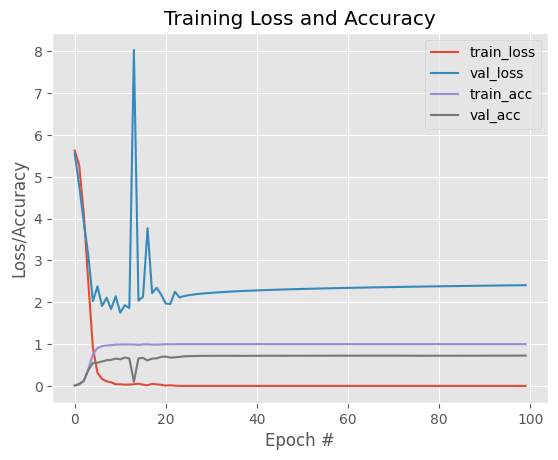

In [ ]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 1s 2ms/step
Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0  7 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  6]]
Accuracy: 0.7194570135746606


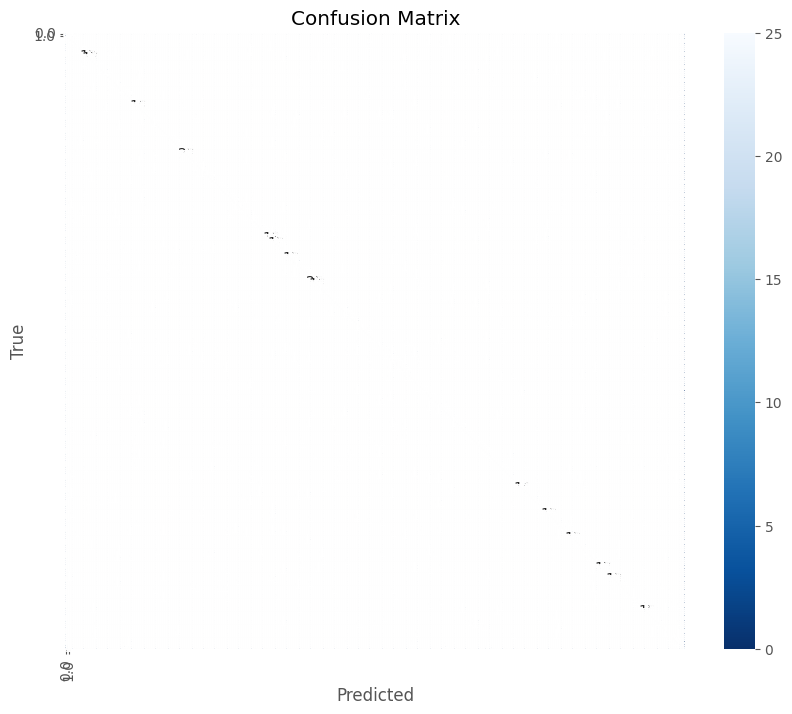

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Intermediate Model

In [ ]:
# Increased number of convolutional blocks

class Intermediate:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()

        # First conv block with activation and MaxPooling
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, depth), padding="same"))
        model.add(MaxPooling2D((2, 2)))

        # Second conv block
        model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2)))

        # Third conv block
        model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2)))

        # Flattens before fully-connected layers
        model.add(Flatten())

        # Fully-connected layers
        model.add(Dense(512, activation='relu'))
        model.add(Dense(classes, activation='softmax'))

        model.summary()
        return model


In [ ]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.005)
model = Intermediate.build(width=94, height=128, depth=1, classes=284)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 128, 94, 32)       320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 64, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 47, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 64, 47, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None,

In [ ]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)),
              batch_size=8, epochs=100, verbose=1)

Training network...
Epoch 1/100
1061/1061 [==============================] - 16s 13ms/step - loss: 5.6330 - accuracy: 0.0090 - val_loss: 5.5455 - val_accuracy: 0.0198
Epoch 2/100
1061/1061 [==============================] - 12s 11ms/step - loss: 5.2008 - accuracy: 0.0332 - val_loss: 4.9441 - val_accuracy: 0.0410
Epoch 3/100
1061/1061 [==============================] - 12s 11ms/step - loss: 3.7469 - accuracy: 0.1687 - val_loss: 3.4071 - val_accuracy: 0.2126
Epoch 4/100
1061/1061 [==============================] - 12s 11ms/step - loss: 1.4899 - accuracy: 0.6085 - val_loss: 2.4371 - val_accuracy: 0.4955
Epoch 5/100
1061/1061 [==============================] - 12s 11ms/step - loss: 0.3243 - accuracy: 0.9082 - val_loss: 1.0840 - val_accuracy: 0.7251
Epoch 6/100
1061/1061 [==============================] - 12s 11ms/step - loss: 0.1029 - accuracy: 0.9716 - val_loss: 1.0263 - val_accuracy: 0.7619
Epoch 7/100
1061/1061 [==============================] - 12s 12ms/step - loss: 0.0393 - accuracy: 

In [ ]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

Evaluating network...
332/332 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

      aaj001       0.90      1.00      0.95         9
      aaj002       1.00      0.90      0.95        10
      abl001       0.90      0.82      0.86        11
      acf001       0.90      1.00      0.95         9
      acl001       0.71      0.71      0.71         7
      acr001       0.67      0.75      0.71         8
      adl001       1.00      0.91      0.95        11
      ais001       0.79      1.00      0.88        11
      ajh001       0.80      0.67      0.73        12
      ajm002       1.00      1.00      1.00         9
      ajt001       0.80      0.94      0.86        17
      ald001       0.77      0.85      0.81        20
      alw001       0.78      0.88      0.82         8
      aor001       0.89      0.89      0.89         9
      apc001       0.80      0.89      0.84         9
      apd001       1.00      0.89      0.94         9
    

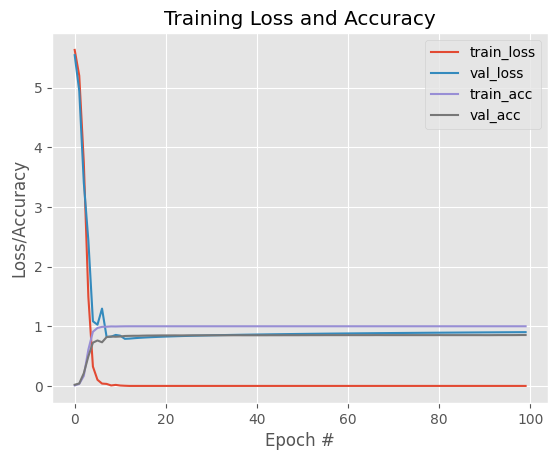

In [ ]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 1s 3ms/step
Confusion Matrix:
[[ 9  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0  9 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  7]]
Accuracy: 0.8623680241327301


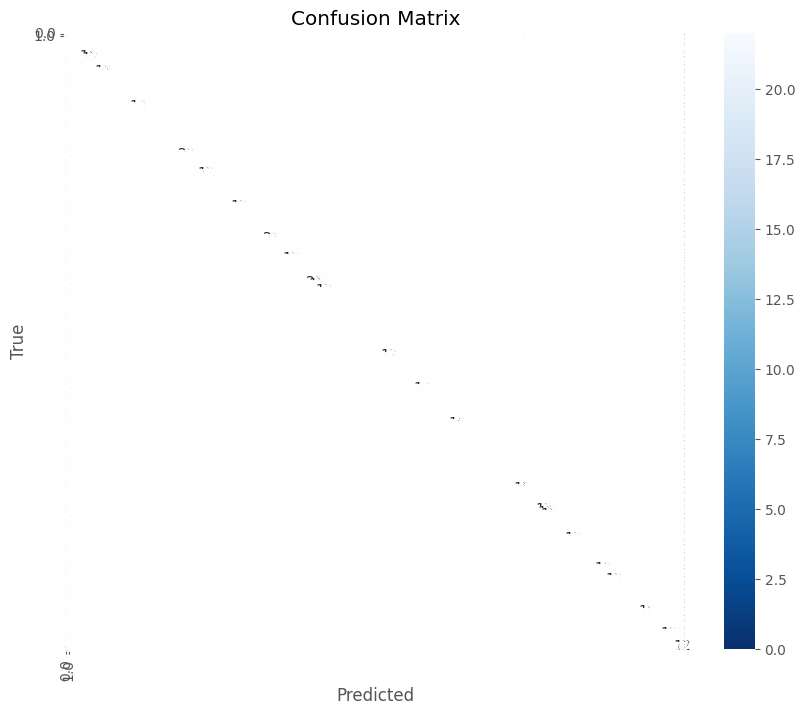

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# VGGNet Model

In [ ]:
class VGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First conv block with activation and MaxPooling
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inputShape, padding="same"))
        model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Second conv block
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Third conv block
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fourth conv block
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fifth conv block
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Softmax classifier
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Dropout layer with a rate of 50%
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Another dropout layer with a rate of 50%
        model.add(Dense(284, activation='softmax'))

        model.summary()
        return model

In [ ]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.005)
model = VGGNet.build(width=94, height=128, depth=1, classes=284)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 94, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 94, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 47, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 23, 64)        0         
 g2D)                                

In [ ]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)),
              batch_size=8, epochs=100, verbose=1)

Training network...
Epoch 1/100
1061/1061 [==============================] - 44s 33ms/step - loss: 5.6422 - accuracy: 0.0074 - val_loss: 5.6081 - val_accuracy: 0.0099
Epoch 2/100
1061/1061 [==============================] - 33s 31ms/step - loss: 5.6237 - accuracy: 0.0088 - val_loss: 5.5985 - val_accuracy: 0.0099
Epoch 3/100
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6030 - accuracy: 0.0079 - val_loss: 5.5929 - val_accuracy: 0.0104
Epoch 4/100
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6036 - accuracy: 0.0097 - val_loss: 5.6236 - val_accuracy: 0.0075
Epoch 5/100
1061/1061 [==============================] - 34s 32ms/step - loss: 5.5940 - accuracy: 0.0093 - val_loss: 5.6057 - val_accuracy: 0.0099
Epoch 6/100
1061/1061 [==============================] - 33s 32ms/step - loss: 5.6088 - accuracy: 0.0093 - val_loss: 5.6054 - val_accuracy: 0.0099
Epoch 7/100
1061/1061 [==============================] - 34s 32ms/step - loss: 5.5846 - accuracy: 

In [ ]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

Evaluating network...
332/332 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

      aaj001       0.90      1.00      0.95         9
      aaj002       1.00      0.80      0.89        10
      abl001       1.00      1.00      1.00        11
      acf001       1.00      0.89      0.94         9
      acl001       1.00      1.00      1.00         7
      acr001       0.86      0.75      0.80         8
      adl001       0.82      0.82      0.82        11
      ais001       0.67      0.91      0.77        11
      ajh001       0.77      0.83      0.80        12
      ajm002       1.00      1.00      1.00         9
      ajt001       0.70      0.94      0.80        17
      ald001       0.72      0.90      0.80        20
      alw001       0.89      1.00      0.94         8
      aor001       0.86      0.67      0.75         9
      apc001       0.90      1.00      0.95         9
      apd001       1.00      0.33      0.50         9
    

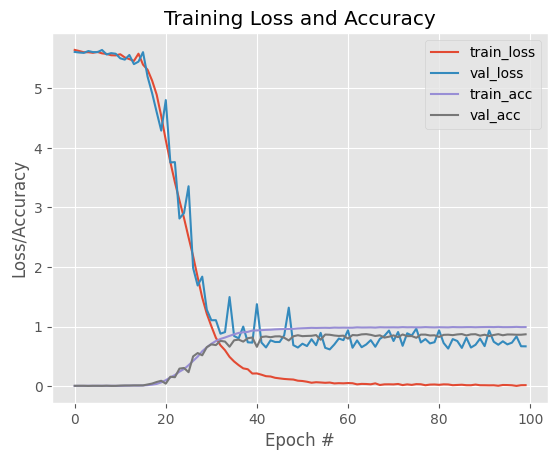

In [ ]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 3s 9ms/step
Confusion Matrix:
[[ 9  0  0 ...  0  0  0]
 [ 0  8  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ...  5  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  7]]
Accuracy: 0.8770739064856712


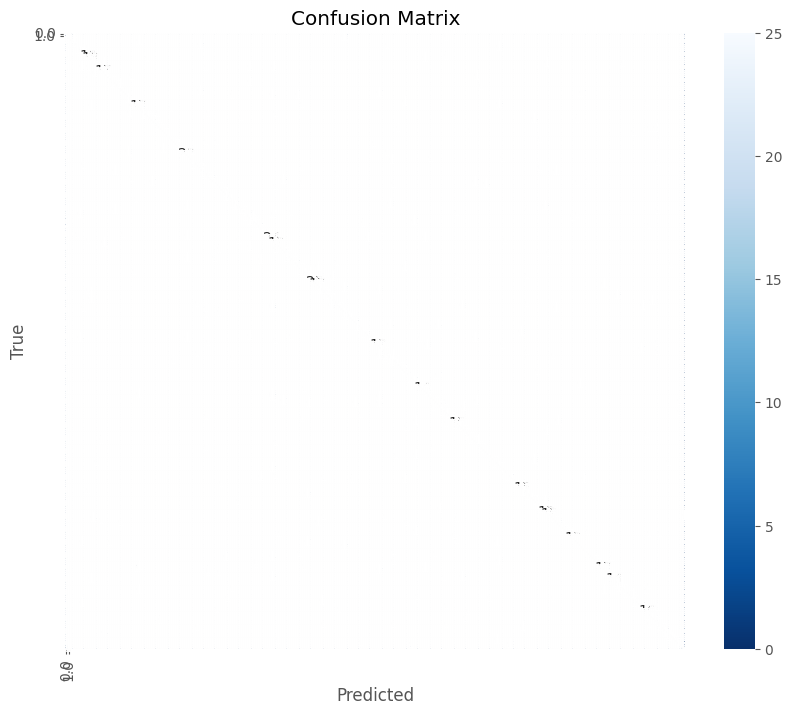

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# VGGNet with more learning

In [ ]:
# Same as VGGNet Model but with 0.01 learning rate and 200 epochs

class VGGNet2:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First conv block with activation and MaxPooling
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inputShape, padding="same"))
        model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Second conv block
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Third conv block
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fourth conv block
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fifth conv block
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Softmax classifier
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Dropout layer with a dropout rate of 50%
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Another dropout layer with a dropout rate of 50%
        model.add(Dense(284, activation='softmax'))

        model.summary()
        return model

In [ ]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.01) # Learning rate increased from 0.005 to 0.01
model = VGGNet2.build(width=94, height=128, depth=1, classes=284)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 94, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 94, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 47, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 23, 64)        0         
 g2D)                         

In [ ]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)),
              batch_size=8, epochs=200, verbose=1)  # Epochs increased from 100 to 200

Training network...
Epoch 1/200
1061/1061 [==============================] - 46s 35ms/step - loss: 5.6414 - accuracy: 0.0081 - val_loss: 5.6181 - val_accuracy: 0.0099
Epoch 2/200
1061/1061 [==============================] - 32s 31ms/step - loss: 5.6210 - accuracy: 0.0079 - val_loss: 5.5830 - val_accuracy: 0.0090
Epoch 3/200
1061/1061 [==============================] - 32s 30ms/step - loss: 5.6167 - accuracy: 0.0094 - val_loss: 5.6305 - val_accuracy: 0.0099
Epoch 4/200
1061/1061 [==============================] - 32s 30ms/step - loss: 5.6186 - accuracy: 0.0092 - val_loss: 5.6163 - val_accuracy: 0.0099
Epoch 5/200
1061/1061 [==============================] - 32s 31ms/step - loss: 5.6121 - accuracy: 0.0094 - val_loss: 5.6156 - val_accuracy: 0.0085
Epoch 6/200
1061/1061 [==============================] - 33s 31ms/step - loss: 5.6086 - accuracy: 0.0090 - val_loss: 5.6068 - val_accuracy: 0.0099
Epoch 7/200
1061/1061 [==============================] - 33s 31ms/step - loss: 5.6128 - accuracy: 

In [ ]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

[INFO] evaluating network...
332/332 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

      aaj001       0.70      0.78      0.74         9
      aaj002       0.69      0.90      0.78        10
      abl001       0.73      0.73      0.73        11
      acf001       0.62      0.56      0.59         9
      acl001       1.00      0.43      0.60         7
      acr001       0.78      0.88      0.82         8
      adl001       1.00      0.55      0.71        11
      ais001       0.92      1.00      0.96        11
      ajh001       0.62      0.42      0.50        12
      ajm002       1.00      0.89      0.94         9
      ajt001       0.73      0.94      0.82        17
      ald001       0.72      0.65      0.68        20
      alw001       0.50      0.38      0.43         8
      aor001       0.83      0.56      0.67         9
      apc001       0.80      0.89      0.84         9
      apd001       0.57      0.44      0.50        

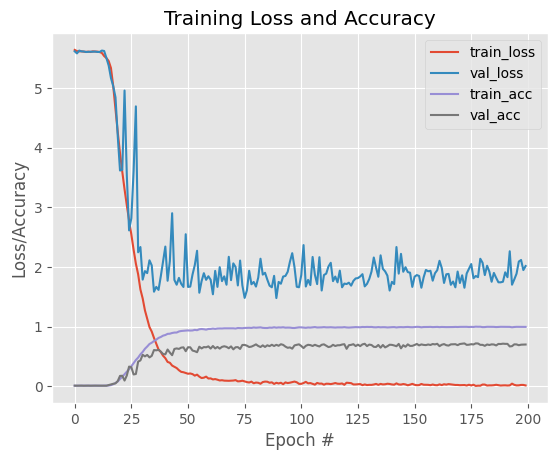

In [ ]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,200), H.history["loss"], label="train_loss")
plt.plot(np.arange(0,200), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,200), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,200), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 3s 9ms/step
Confusion Matrix:
[[7 0 0 ... 0 0 0]
 [0 9 0 ... 0 0 0]
 [0 0 8 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 9 0]
 [0 0 0 ... 0 0 7]]
Accuracy: 0.7126696832579186


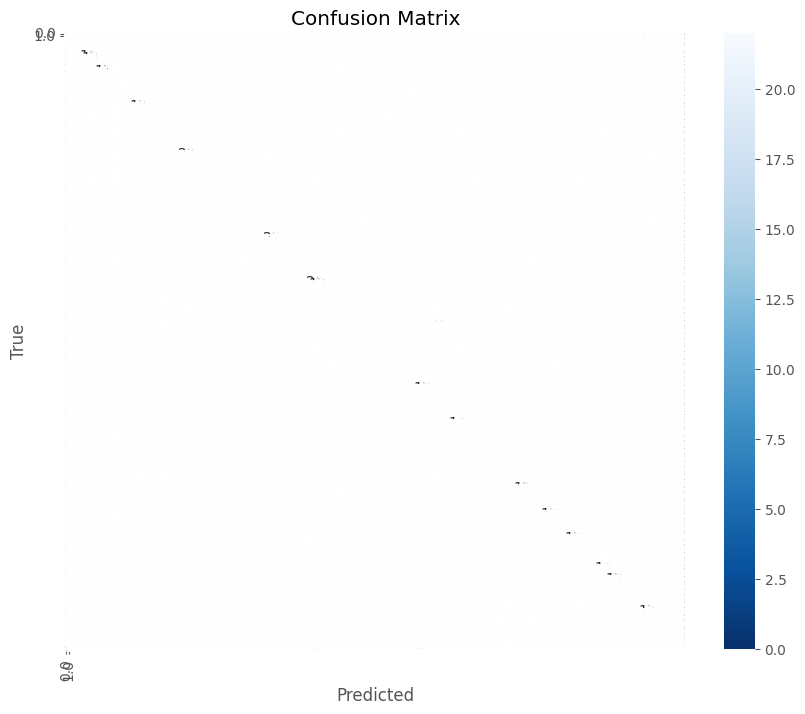

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# VGGNet with early stopping

In [ ]:
# Added early stopping to VGGNet Model and changed learning rate to 0.004 with 150 epochs and third dropout layer

class VGGNet3:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First conv block with activation and MaxPooling
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inputShape, padding="same"))
        model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Second conv block
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Third conv block
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fourth conv block
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fifth conv block
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Softmax classifier
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Dropout layer with a dropout rate of 50%
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Another dropout layer with a rate of 50%
        model.add(Dense(284, activation='softmax'))
        model.add(Dropout(0.5))  # Third dropout layer
        model.add(Dense(284, activation='softmax'))

        model.summary()
        return model

In [ ]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.004)
model = VGGNet3.build(width=94, height=128, depth=1, classes=284)

# Defines early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 94, 32)       320       
                                                                 
 conv2d_14 (Conv2D)          (None, 128, 94, 32)       9248      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 47, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 47, 64)        18496     
                                                                 
 conv2d_16 (Conv2D)          (None, 64, 47, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 23, 64)        0         
 g2D)                              

In [ ]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), callbacks=[early_stopping],
              batch_size=8, epochs=150, verbose=1)

Training network...
Epoch 1/150
1061/1061 [==============================] - 38s 33ms/step - loss: 5.6486 - accuracy: 0.0052 - val_loss: 5.6476 - val_accuracy: 0.0099
Epoch 2/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.6472 - accuracy: 0.0091 - val_loss: 5.6463 - val_accuracy: 0.0099
Epoch 3/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6460 - accuracy: 0.0097 - val_loss: 5.6450 - val_accuracy: 0.0099
Epoch 4/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.6447 - accuracy: 0.0097 - val_loss: 5.6437 - val_accuracy: 0.0099
Epoch 5/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.6435 - accuracy: 0.0098 - val_loss: 5.6425 - val_accuracy: 0.0099
Epoch 6/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.6422 - accuracy: 0.0099 - val_loss: 5.6414 - val_accuracy: 0.0099
Epoch 7/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.6412 - accuracy: 

In [ ]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

Evaluating network...
332/332 [==============================] - 3s 7ms/step
              precision    recall  f1-score   support

      aaj001       0.00      0.00      0.00         9
      aaj002       0.00      0.00      0.00        10
      abl001       0.00      0.00      0.00        11
      acf001       0.00      0.00      0.00         9
      acl001       0.00      0.00      0.00         7
      acr001       0.00      0.00      0.00         8
      adl001       0.00      0.00      0.00        11
      ais001       0.00      0.00      0.00        11
      ajh001       0.00      0.00      0.00        12
      ajm002       0.00      0.00      0.00         9
      ajt001       0.00      0.00      0.00        17
      ald001       0.00      0.00      0.00        20
      alw001       0.00      0.00      0.00         8
      aor001       0.00      0.00      0.00         9
      apc001       0.00      0.00      0.00         9
      apd001       0.00      0.00      0.00         9
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,150), H.history["loss"], label="train_loss") # change the second part of parantheses to match last epoch
plt.plot(np.arange(0,150), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,150), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,150), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

NameError: name 'H' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# VGGNet Take Two

In [ ]:
# VGGNet Model with early stopping and learning rate of 0.005

class VGGNet4:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First conv block with activation and MaxPooling
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inputShape, padding="same"))
        model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Second conv block
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Third conv block
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fourth conv block
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fifth conv block
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Softmax classifier
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Dropout layer with a dropout rate of 50%
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Another dropout layer with a rate of 50%
        model.add(Dense(284, activation='softmax'))
        model.add(Dropout(0.5))  # Third dropout layer
        model.add(Dense(284, activation='softmax'))

        model.summary()
        return model

In [ ]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.005)
model = VGGNet4.build(width=94, height=128, depth=1, classes=284)

# Defines early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 94, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 94, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 47, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 23, 64)        0         
 g2D)                         

In [ ]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)),
              batch_size=8, epochs=150, verbose=1)

Training network...
Epoch 1/150
1061/1061 [==============================] - 44s 33ms/step - loss: 5.6448 - accuracy: 0.0054 - val_loss: 5.6258 - val_accuracy: 0.0099
Epoch 2/150
1061/1061 [==============================] - 33s 31ms/step - loss: 5.6204 - accuracy: 0.0086 - val_loss: 5.6211 - val_accuracy: 0.0099
Epoch 3/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.5943 - accuracy: 0.0094 - val_loss: 5.5763 - val_accuracy: 0.0113
Epoch 4/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.5759 - accuracy: 0.0094 - val_loss: 5.6220 - val_accuracy: 0.0099
Epoch 5/150
1061/1061 [==============================] - 39s 37ms/step - loss: 5.5769 - accuracy: 0.0104 - val_loss: 5.6220 - val_accuracy: 0.0085
Epoch 6/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.5826 - accuracy: 0.0095 - val_loss: 5.5340 - val_accuracy: 0.0099
Epoch 7/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6124 - accuracy: 

In [ ]:
# Evalutes the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

[INFO] evaluating network...
332/332 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

      aaj001       1.00      0.89      0.94         9
      aaj002       1.00      1.00      1.00        10
      abl001       0.85      1.00      0.92        11
      acf001       1.00      0.78      0.88         9
      acl001       0.88      1.00      0.93         7
      acr001       0.75      0.75      0.75         8
      adl001       1.00      0.82      0.90        11
      ais001       0.67      0.91      0.77        11
      ajh001       0.89      0.67      0.76        12
      ajm002       1.00      1.00      1.00         9
      ajt001       0.88      0.88      0.88        17
      ald001       0.94      0.85      0.89        20
      alw001       1.00      0.88      0.93         8
      aor001       1.00      0.67      0.80         9
      apc001       0.90      1.00      0.95         9
      apd001       0.75      0.67      0.71        

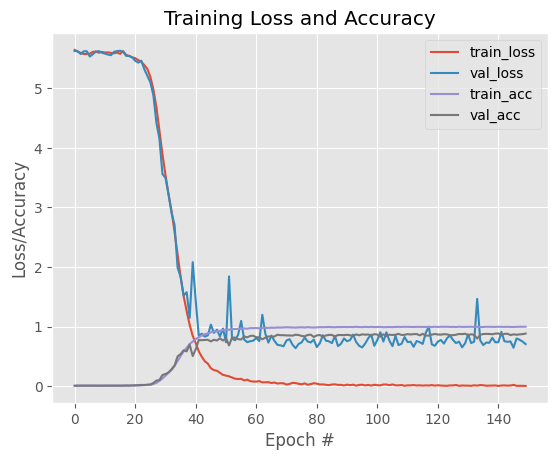

In [ ]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,150), H.history["loss"], label="train_loss") # change the second part of parantheses to match last epoch
plt.plot(np.arange(0,150), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,150), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,150), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 3s 8ms/step
Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 0 10  0 ...  0  0  0]
 [ 0  0 11 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  0  0 ...  0 12  0]
 [ 0  0  0 ...  0  0  6]]
Accuracy: 0.8785822021116139


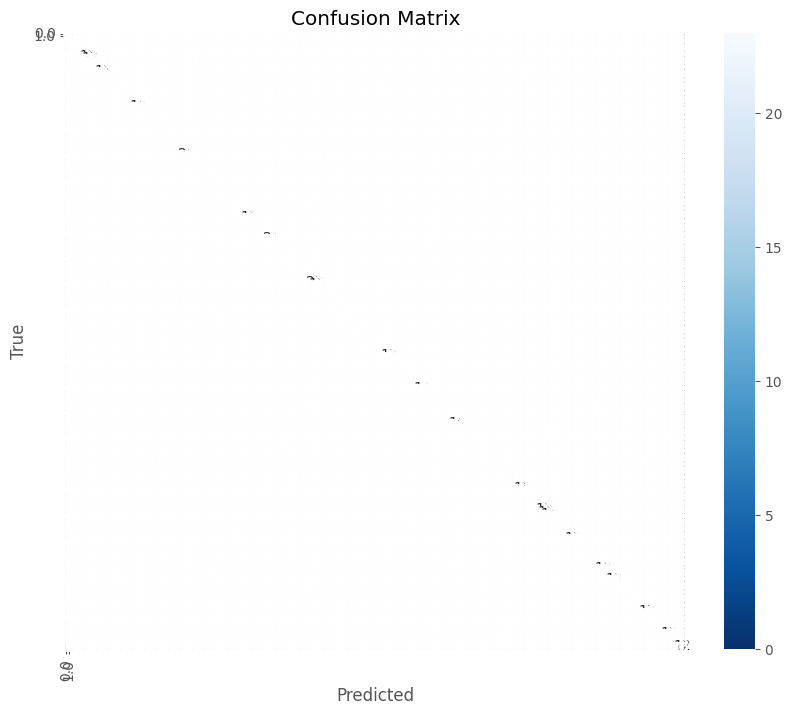

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# VGGNet again

In [9]:
# VGGNet Model with early stopping, third dropout layer, learning rate of 0.007, and 150 epochs

class VGGNet5:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)

        # First conv block with activation and MaxPooling
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=inputShape, padding="same"))
        model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Second conv block
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(Conv2D(64, (3,3), activation='relu',padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Third conv block
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(128, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fourth conv block
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(256, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Fifth conv block
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(Conv2D(512, (3,3), activation='relu', padding="same"))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))

        # Softmax classifier
        model.add(Flatten())
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Dropout layer with a dropout rate of 50%
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))  # Another dropout layer with a rate of 50%
        model.add(Dense(284, activation='softmax'))
        model.add(Dropout(0.5))  # Third dropout layer
        model.add(Dense(284, activation='softmax'))

        model.summary()
        return model

In [10]:
# Initializes the optimizer and model
print("Compiling model...")
opt = SGD(learning_rate=0.007)
model = VGGNet5.build(width=94, height=128, depth=1, classes=284)

# Defines early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 94, 32)       320       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 94, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 47, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 47, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 47, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 23, 64)        0         
 g2D)                                

In [11]:
# Trains the network
print("Training network...")
H = model.fit(np.array(X_train), np.array(y_train), validation_data=(np.array(X_val), np.array(y_val)), callbacks=[early_stopping],
              batch_size=8, epochs=150, verbose=1)

Training network...
Epoch 1/150
1061/1061 [==============================] - 47s 36ms/step - loss: 5.6483 - accuracy: 0.0059 - val_loss: 5.6466 - val_accuracy: 0.0099
Epoch 2/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6459 - accuracy: 0.0085 - val_loss: 5.6444 - val_accuracy: 0.0099
Epoch 3/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.6438 - accuracy: 0.0098 - val_loss: 5.6422 - val_accuracy: 0.0099
Epoch 4/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6417 - accuracy: 0.0099 - val_loss: 5.6402 - val_accuracy: 0.0099
Epoch 5/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6397 - accuracy: 0.0099 - val_loss: 5.6383 - val_accuracy: 0.0099
Epoch 6/150
1061/1061 [==============================] - 35s 33ms/step - loss: 5.6380 - accuracy: 0.0099 - val_loss: 5.6365 - val_accuracy: 0.0099
Epoch 7/150
1061/1061 [==============================] - 34s 32ms/step - loss: 5.6362 - accuracy: 

In [12]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

Evaluating network...
332/332 [==============================] - 3s 9ms/step
              precision    recall  f1-score   support

      aaj001       0.00      0.00      0.00         9
      aaj002       0.00      0.00      0.00        10
      abl001       0.00      0.00      0.00        11
      acf001       0.00      0.00      0.00         9
      acl001       0.00      0.00      0.00         7
      acr001       0.00      0.00      0.00         8
      adl001       0.00      0.00      0.00        11
      ais001       0.00      0.00      0.00        11
      ajh001       0.00      0.00      0.00        12
      ajm002       0.00      0.00      0.00         9
      ajt001       0.00      0.00      0.00        17
      ald001       0.00      0.00      0.00        20
      alw001       0.00      0.00      0.00         8
      aor001       0.00      0.00      0.00         9
      apc001       0.00      0.00      0.00         9
      apd001       0.00      0.00      0.00         9
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


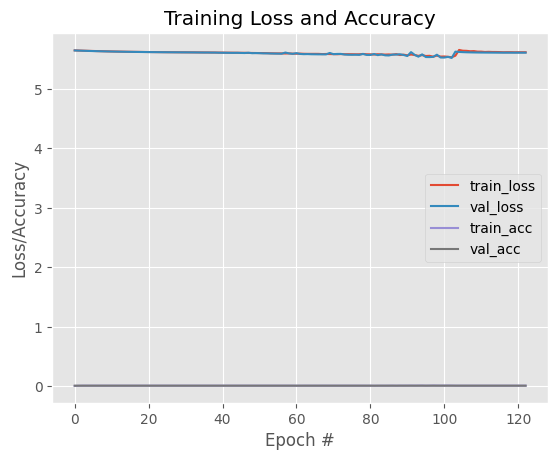

In [14]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,123), H.history["loss"], label="train_loss") # change the second part of parantheses to match last epoch
plt.plot(np.arange(0,123), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,123), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,123), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 2s 7ms/step
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy: 0.00980392156862745


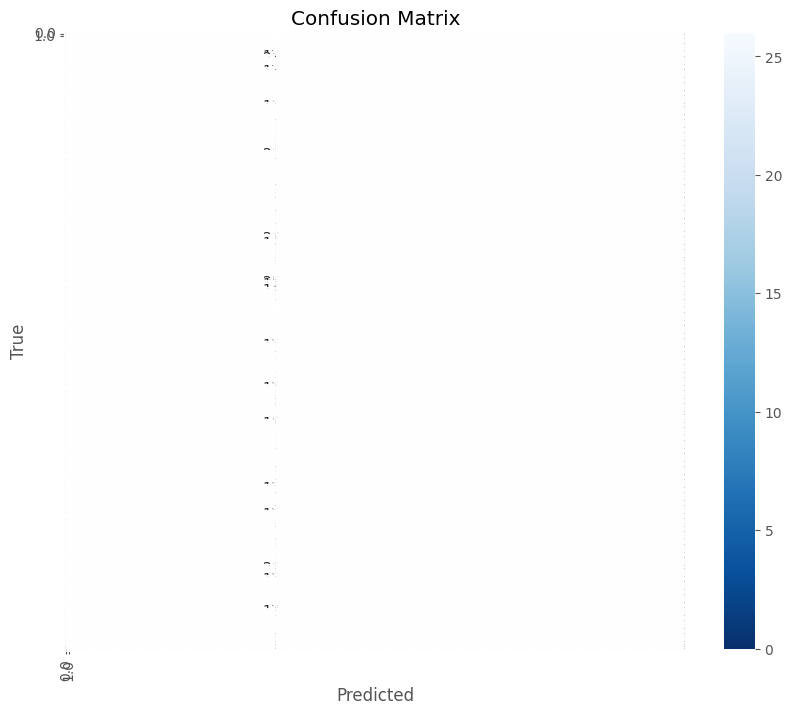

In [15]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#  CNN with LSTM

In [ ]:
# Defines the CNN Model with LSTM layer
def cnn_lstm_model(width, height, depth, num_time_steps, num_features, classes):
    model = Sequential()

    # CNN layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, depth)))
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, depth)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flattens before LSTM layer
    model.add(Flatten())

    # Reshapes the output of the CNN to fit into LSTM
    model.add(Reshape((num_time_steps, -1)))

    # LSTM layer
    model.add(LSTM(50, return_sequences=False))
    model.add(Flatten())  # Adds a Flatten layer to convert the LSTM output to a vector


    # Fully connected layers for classification
    model.add(Dense(512, activation='relu'))
    model.add(Dense(284, activation='softmax'))

    # Initializes the model with Adam optimizer
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()
    return model

In [ ]:
# Sets parameter values
width = 94
height = 128
depth = 1
num_time_steps = 128
num_features = 94
classes = 284

# Creates the model
model = cnn_lstm_model(width, height, depth, num_time_steps, num_features, classes)

# Reshapes the input data
X_train_cnn = np.reshape(X_train, (-1, height, width, depth))
X_val_cnn = np.reshape(X_val, (-1, height, width, depth))

assert len(X_train_cnn) == len(y_train) # Number of samples in X_train and y_train should match
assert len(X_val_cnn) == len(y_val)


# Trains the model
H = model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val), batch_size=32, epochs=100, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 92, 32)       320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 46, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 44, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 22, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 20, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 10, 128)      

In [ ]:
# Evaluates the network
labels_encoder = LabelEncoder().fit(labels)
print("Evaluating network...")
predictions = model.predict(np.array(X_test), batch_size=8)
print(classification_report(np.array(y_test).argmax(axis=1),
     predictions.argmax(axis=1),
     target_names=labels_encoder.classes_))

Evaluating network...
332/332 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

      aaj001       0.00      0.00      0.00         9
      aaj002       0.00      0.00      0.00        10
      abl001       0.00      0.00      0.00        11
      acf001       0.00      0.00      0.00         9
      acl001       0.00      0.00      0.00         7
      acr001       0.00      0.00      0.00         8
      adl001       0.00      0.00      0.00        11
      ais001       0.00      0.00      0.00        11
      ajh001       0.00      0.00      0.00        12
      ajm002       0.00      0.00      0.00         9
      ajt001       0.00      0.00      0.00        17
      ald001       0.00      0.00      0.00        20
      alw001       0.00      0.00      0.00         8
      aor001       0.00      0.00      0.00         9
      apc001       0.00      0.00      0.00         9
      apd001       0.00      0.00      0.00         9
    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


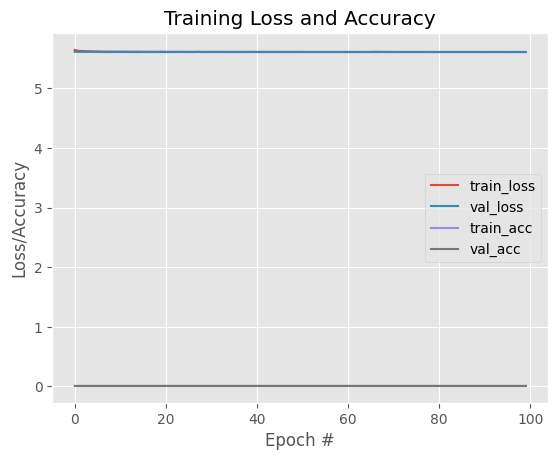

In [ ]:
# Plots the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0,100), H.history["loss"], label="train_loss") # change the second part of parantheses to match last epoch
plt.plot(np.arange(0,100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

332/332 [==============================] - 1s 4ms/step
Confusion Matrix:
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
Accuracy: 0.00980392156862745


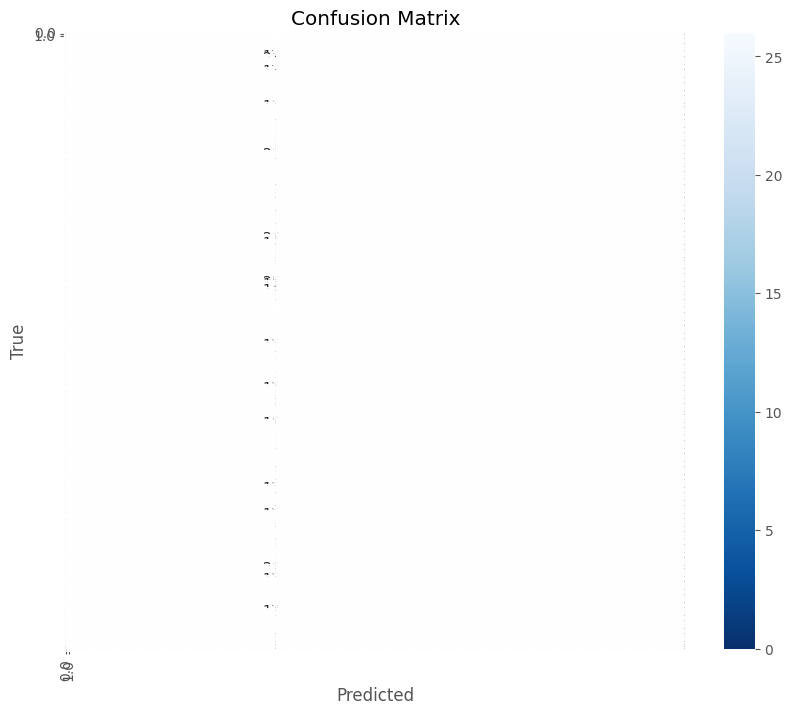

In [ ]:
# Generates the confusion matrix
predictions = model.predict(np.array(X_test), batch_size=8)
conf_matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Calculates the accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), predictions.argmax(axis=1))
print("Accuracy:", accuracy)

# Displays the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues_r', xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()